In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.patches as mpatches
import shap
import os
import pandas as pd

2024-07-11 19:29:20.967014: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 19:29:21.195611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set matplotlib default color cycle
new_color_cycle = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#aec7e8',
    '#ffbb78',
    '#98df8a',
    '#ff9896',
    '#c5b0d5',
    '#c49c94',
    '#f7b6d2',
    '#c7c7c7',
    '#dbdb8d',
    '#9edae5'
]

# You can then apply this new color cycle to your matplotlib plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=new_color_cycle)

In [3]:
# This is the list that will hold all of the data (data22 and MC)

datasets = {}

## Collect Data

In [4]:
with h5py.File('../../../../ntuples/AOD_EB_ntuples_05-22-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    ofl_jets = hf['ofl_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    ofl_electrons = hf['ofl_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    ofl_muons = hf['ofl_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    ofl_photons = hf['ofl_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 3)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]
    event_number = hf["event_number"][:]
    run_number = hf["run_number"][:]


# Concatenate HLT data
HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)

datasets['data22_EB'] = {
    'HLT_data': HLT_objects,
    'L1_data': L1_objects,
    'passL1': pass_L1_unprescaled==1,
    'passHLT': pass_HLT_unprescaled==1,
    'weights': EB_weights,
    'event_numbers': event_number,
    'run_numbers': run_number
}

In [5]:
# Read MC data.

data_path = '../../../../ntuples/MC_07-10-2024/'

for filename in os.listdir(data_path):

    if filename.startswith('N') or filename.startswith('.'): continue

    dataset_tag = filename.split('_')[0]
    
    with h5py.File(data_path+filename, 'r') as hf:
        HLT_jets = hf['HLT_jets'][:]
        L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
        L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
        HLT_electrons = hf['HLT_electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        L1_egammas = hf['L1_egammas'][:]
        HLT_muons = hf['HLT_muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        L1_muons = hf['L1_muons'][:]
        L1_eFex_taus = hf['L1_eFex_taus'][:]
        L1_jFex_taus = hf['L1_jFex_taus'][:]
        HLT_photons = hf['HLT_photons'][:]
        HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]

        HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons[:, :3, [0, 2, 3]], HLT_muons[:, :3, [0, 2, 3]], HLT_photons[:, :3, [0, 2, 3]], HLT_MET[:, :, [0, 2, 3]]], axis=1)
        L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas[:, :3, :], L1_muons[:, :3, :], L1_eFex_taus[:, :3, :], L1_MET], axis=1)
        
        datasets[dataset_tag] = {
            'HLT_data': HLT_objects,
            'L1_data': L1_objects,
            'passL1': pass_L1_unprescaled==1,
            'passHLT': pass_HLT_unprescaled==1,
            'weights': np.ones(len(HLT_objects)),
        }

In [6]:
# Read 2024 EB data

with h5py.File('../../../../ntuples/EB_473255_ntuples_07-10-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    ofl_jets = hf['ofl_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    ofl_electrons = hf['ofl_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    ofl_muons = hf['ofl_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    ofl_photons = hf['ofl_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 3)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]
    event_number = hf["event_number"][:]
    run_number = hf["run_number"][:]

HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons[:, :3, :], HLT_muons[:, :3, :], HLT_photons[:, :3, :], HLT_MET], axis=1)
L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas[:, :3, :], L1_muons[:, :3, :], L1_eFex_taus[:, :3, :], L1_MET], axis=1)

datasets['473255_EB'] = {
    'HLT_data': HLT_objects,
    'L1_data': L1_objects,
    'passL1': pass_L1_unprescaled==1,
    'passHLT': pass_HLT_unprescaled==1,
    'weights': EB_weights,
    'event_numbers': event_number,
    'run_numbers': run_number
}

In [7]:
for tag, dict in datasets.items():
    print(f'\n{tag}:')
    for key, value in dict.items():
        print(f'{key}: {value.shape}')


data22_EB:
HLT_data: (2059879, 20, 3)
L1_data: (2059879, 20, 3)
passL1: (2059879,)
passHLT: (2059879,)
weights: (2059879,)
event_numbers: (2059879,)
run_numbers: (2059879,)

A14N23LO:
HLT_data: (10000, 20, 3)
L1_data: (10000, 20, 3)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)

HAHMggfZdZd2l2nu:
HLT_data: (70000, 20, 3)
L1_data: (70000, 20, 3)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)

HHbbttHadHad:
HLT_data: (350000, 20, 3)
L1_data: (350000, 20, 3)
passL1: (350000,)
passHLT: (350000,)
weights: (350000,)

ZZ4lep:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

Zprime2EJs:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ1:
HLT_data: (1000000, 20, 3)
L1_data: (1000000, 20, 3)
passL1: (1000000,)
passHLT: (1000000,)
weights: (1000000,)

jjJZ2:
HLT_data: (1000000, 20, 3)
L1_data: (1000000, 20, 3)
passL1: (1000000,)
passHLT: (1000000,)
weights: (1000

In [8]:
# In the EB sets, only take events that either passed L1, or are L1Seeded

mask = datasets['data22_EB']['passL1']
for label, data in datasets['data22_EB'].items():
    datasets['data22_EB'][label] = data[mask]

mask = datasets['473255_EB']['passL1']
for label, data in datasets['473255_EB'].items():
    datasets['473255_EB'][label] = data[mask]

In [9]:
"""Multiply the et of the L1 muons by 1000 to get them into the right units."""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label == 'L1_data':
            data[:, 13:16, 0] *= 1000

In [10]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label.endswith('data'):

            # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
            MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
            MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
            MET_nan = np.isnan(data[:, 19, 2])
            data[MET_zeros, 19, 0] = 0.001
            data[MET_999, 19, :] = 0
            data[MET_nan, 19, :] = 0

In [11]:
"""Normalize pt such that sum(pt) = 10 in each event"""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label.endswith('data'):
            # sum of the pt and E in each event
            sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)
        
            # If the sum is 0, set the sum to 1 to avoid division by 0
            sum_pt[sum_pt == 0] = 1
        
            # Divide pt and E by their respective sums, multiply by 10
            data[:, :, 0] *= (10/sum_pt)

In [12]:
# Split EB data in train, test

random_seed = 0

indices = np.arange(len(datasets['473255_EB']['HLT_data']))
train_indices, _indices = train_test_split(indices, train_size=0.5, random_state=random_seed)
test1_indices, test2_indices = train_test_split(_indices, train_size=0.5, random_state=random_seed)

datasets['EB_train'] = {key:value[train_indices] for key, value in datasets['473255_EB'].items()}
datasets['EB_test1'] = {key:value[test1_indices] for key, value in datasets['473255_EB'].items()}
datasets['EB_test2'] = {key:value[test2_indices] for key, value in datasets['473255_EB'].items()}

del datasets['473255_EB']

In [13]:
# Flatten ndarrays for use in DNN

for tag, dict in datasets.items():
    for label, data in dict.items():
        if label.endswith('data'):
            datasets[tag][label] = np.reshape(data, newshape=(-1, 60))

# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')


data22_EB:
HLT_data: (353019, 60)
L1_data: (353019, 60)
passL1: (353019,)
passHLT: (353019,)
weights: (353019,)
event_numbers: (353019,)
run_numbers: (353019,)

A14N23LO:
HLT_data: (10000, 60)
L1_data: (10000, 60)
passL1: (10000,)
passHLT: (10000,)
weights: (10000,)

HAHMggfZdZd2l2nu:
HLT_data: (70000, 60)
L1_data: (70000, 60)
passL1: (70000,)
passHLT: (70000,)
weights: (70000,)

HHbbttHadHad:
HLT_data: (350000, 60)
L1_data: (350000, 60)
passL1: (350000,)
passHLT: (350000,)
weights: (350000,)

ZZ4lep:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

Zprime2EJs:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
weights: (100000,)

jjJZ1:
HLT_data: (1000000, 60)
L1_data: (1000000, 60)
passL1: (1000000,)
passHLT: (1000000,)
weights: (1000000,)

jjJZ2:
HLT_data: (1000000, 60)
L1_data: (1000000, 60)
passL1: (1000000,)
passHLT: (1000000,)
weights: (1000000,)

jjJZ4:
HLT_data: (650000, 60)
L1_data: (650000, 

## Network Infrastructure

In [14]:
def create_AE(input_dim, h_dim_1, h_dim_2, h_dim_3, h_dim_4, latent_dim):
    
     # Encoder
    encoder_inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(encoder_inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    x = layers.Dense(h_dim_3, activation='relu')(x)
    x = layers.Dense(h_dim_4, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)
    
    encoder = Model(inputs=encoder_inputs, outputs=z)

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h_dim_4, activation='relu')(decoder_inputs)
    x = layers.Dense(h_dim_3, activation='relu')(x)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    decoder = Model(inputs=decoder_inputs, outputs=outputs)

    ae_outputs = decoder(encoder(encoder_inputs))
    ae = Model(encoder_inputs, outputs=ae_outputs)

    return ae, encoder, decoder

In [15]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    mask = mask0 * maskMET
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

## Train

In [16]:
# Initialize models
INPUT_DIM = datasets['EB_train']['HLT_data'].shape[1]
H_DIM_1 = 100
H_DIM_2 = 100
H_DIM_3 = 64
H_DIM_4 = 32
LATENT_DIM = 12

HLT_AE, HLT_encoder, HLT_decoder = create_AE(INPUT_DIM, H_DIM_1, H_DIM_2, H_DIM_3, H_DIM_4, LATENT_DIM)
L1_AE, L1_encoder, L1_decoder = create_AE(INPUT_DIM, H_DIM_1, H_DIM_2, H_DIM_3, H_DIM_4, LATENT_DIM)

HLT_AE.summary()
L1_AE.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 model (Functional)          (None, 12)                25140     
                                                                 
 model_1 (Functional)        (None, 60)                25188     
                                                                 
Total params: 50328 (196.59 KB)
Trainable params: 50328 (196.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60)]              0         
                                                                 
 mod

In [17]:
HLT_AE.compile(optimizer='adam', loss=loss_fn)
L1_AE.compile(optimizer='adam', loss=loss_fn)

In [18]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 6
LR_PATIENCE = 4

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [19]:
NUM_EPOCHS = 200
BATCH_SIZE = 512

In [20]:
# train HLT model
history = HLT_AE.fit(
    x=datasets['EB_train']['HLT_data'], 
    y=datasets['EB_train']['HLT_data'], 
    validation_split=0.15, 
    epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=callbacks, 
    sample_weight = datasets['EB_train']['weights']
)

Epoch 1/200
159/159 [==============================] - 4s 9ms/step - loss: 1054.0276 - val_loss: 803.1669 - lr: 0.0010
Epoch 2/200
159/159 [==============================] - 1s 6ms/step - loss: 725.6332 - val_loss: 665.0969 - lr: 0.0010
Epoch 3/200
159/159 [==============================] - 1s 6ms/step - loss: 655.5565 - val_loss: 623.2667 - lr: 0.0010
Epoch 4/200
159/159 [==============================] - 1s 7ms/step - loss: 630.0374 - val_loss: 610.5143 - lr: 0.0010
Epoch 5/200
159/159 [==============================] - 1s 6ms/step - loss: 619.4036 - val_loss: 608.0906 - lr: 0.0010
Epoch 6/200
159/159 [==============================] - 1s 6ms/step - loss: 614.2332 - val_loss: 604.3193 - lr: 0.0010
Epoch 7/200
159/159 [==============================] - 1s 7ms/step - loss: 610.6045 - val_loss: 598.6975 - lr: 0.0010
Epoch 8/200
159/159 [==============================] - 1s 7ms/step - loss: 609.9242 - val_loss: 596.1630 - lr: 0.0010
Epoch 9/200
159/159 [==============================] - 

In [21]:
HLT_AE.save_weights('./trained_models/EB_HLT_vl103.keras')
HLT_encoder.save_weights('./trained_models/EB_HLT_encoder_vl103.keras')

In [20]:
HLT_AE.load_weights('./trained_models/EB_HLT_vl103.keras')
HLT_encoder.load_weights('./trained_models/EB_HLT_encoder_vl103.keras')

In [22]:
# train L1 model
# train HLT model
history = L1_AE.fit(
    x=datasets['EB_train']['L1_data'], 
    y=datasets['EB_train']['L1_data'], 
    validation_split=0.15, 
    epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=callbacks, 
    sample_weight = datasets['EB_train']['weights']
)

Epoch 1/200
159/159 [==============================] - 3s 8ms/step - loss: 427.4388 - val_loss: 289.2468 - lr: 0.0010
Epoch 2/200
159/159 [==============================] - 1s 6ms/step - loss: 240.8919 - val_loss: 198.9713 - lr: 0.0010
Epoch 3/200
159/159 [==============================] - 1s 6ms/step - loss: 190.3597 - val_loss: 176.8898 - lr: 0.0010
Epoch 4/200
159/159 [==============================] - 1s 7ms/step - loss: 168.2047 - val_loss: 156.0508 - lr: 0.0010
Epoch 5/200
159/159 [==============================] - 1s 6ms/step - loss: 153.6993 - val_loss: 147.2284 - lr: 0.0010
Epoch 6/200
159/159 [==============================] - 1s 7ms/step - loss: 145.1363 - val_loss: 140.5854 - lr: 0.0010
Epoch 7/200
159/159 [==============================] - 1s 7ms/step - loss: 139.9892 - val_loss: 136.0620 - lr: 0.0010
Epoch 8/200
159/159 [==============================] - 1s 6ms/step - loss: 136.2334 - val_loss: 133.1727 - lr: 0.0010
Epoch 9/200
159/159 [==============================] - 1

In [23]:
L1_AE.save_weights('./trained_models/EB_L1_vl103.keras')
L1_encoder.save_weights('./trained_models/EB_L1_encoder_vl103.keras')

In [21]:
L1_AE.load_weights('./trained_models/EB_L1_vl103.keras')
L1_encoder.load_weights('./trained_models/EB_L1_encoder_vl103.keras')

# Evaluate Model

## SHAP

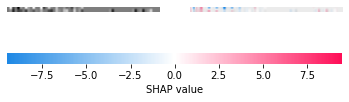

In [28]:
background = datasets['HLT_test1'][np.random.choice(datasets['HLT_test1'].shape[0], 100, replace=False)]

e = shap.DeepExplainer(HLT_AE, background)

shap_values = e.shap_values(datasets['HLT_test2'][0:2])


shap.image_plot(shap_values, -datasets['HLT_test2'][0:2])

<Figure size 864x576 with 0 Axes>

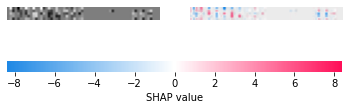

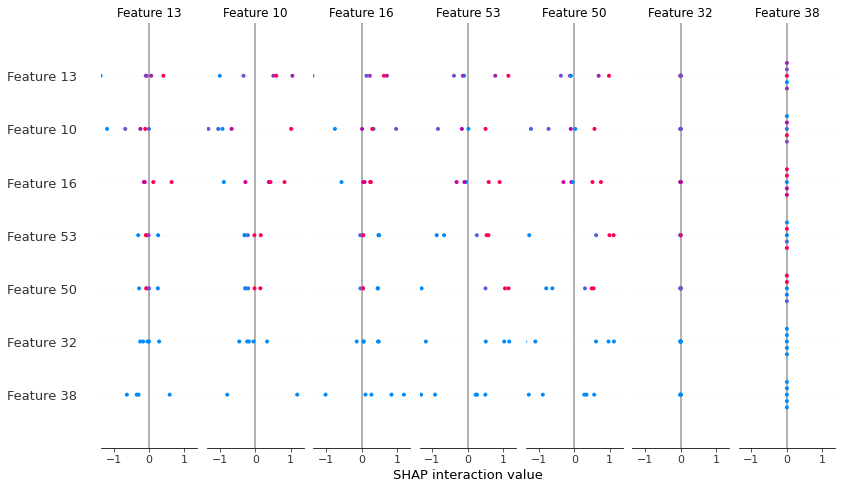

In [30]:
# Set up the background data
background = datasets['HLT_test1'][np.random.choice(datasets['HLT_test1'].shape[0], 100, replace=False)]

# Initialize SHAP DeepExplainer
e = shap.DeepExplainer(HLT_AE, background)

# Compute SHAP values for a subset of test data
shap_values = e.shap_values(datasets['HLT_test2'][0:5])

# Adjust plot size and plot SHAP values
plt.figure(figsize=(12, 8))
shap.image_plot(shap_values, -datasets['HLT_test2'][0:5])

# Alternatively, use summary plot for better insights
shap.summary_plot(shap_values, datasets['HLT_test2'][0:5])

## Normal Eval

In [22]:
# Pass the datasets through the model

for tag, dict in datasets.items():
    if tag == 'EB_train': continue

    dict['HLT_model_outputs'] = HLT_AE.predict(dict['HLT_data'])
    dict['HLT_latent_reps'] = HLT_encoder.predict(dict['HLT_data'])
    dict['L1_model_outputs'] = L1_AE.predict(dict['L1_data'])
    dict['L1_latent_reps'] = L1_encoder.predict(dict['L1_data'])

1759/2188 [=======================>......] - ETA: 0s

KeyboardInterrupt: 

In [ ]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [ ]:
def MSE_AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [ ]:
# Calculate the AD scores

for tag, dict in datasets.items():
    if tag == 'EB_train': continue

    dict['HLT_AD_scores'] = MSE_AD_score(dict['HLT_data'], dict['HLT_model_outputs'])
    dict['L1_AD_scores'] = MSE_AD_score(dict['L1_data'], dict['L1_model_outputs'])

In [ ]:
# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')

In [ ]:
def ROC_curve(dataset, bkg_type, plot=True):
    """
    Plots ROC curve and returns AUC and FPRs for each dataset.
    
    inputs: 
    AD_scores: dictionary {datset_names: AD_scores}
    weights_dict: dictionary {dataset_names: sample weights}
    bkg_tag: the name of the dataset that correspondds to the background.
    
    returns:
    TPRs: dictionary {dataset_names: TPR at FPR=10e-4}
    AUCs: dictionary {dataset_names: AUC}
    """
    
    bkg_tag = 'EB_test1'
    target_fpr = 10**-4
    plt.figure(figsize=(8.5,6.8))
    
    TPRs = {}
    AUCs = {}
    thresholds = {}
    
    for tag in datasets.keys():
        if tag != bkg_tag and tag != 'EB_train':
        
            # Combine true labels, anomaly=1 and background=0
            trueVal = np.concatenate((np.ones(dataset[tag][f'{bkg_type}_AD_scores'].shape[0]), np.zeros(dataset[bkg_tag][f'{bkg_type}_AD_scores'].shape[0])))
            
            # Combine predictions from current dataset and background
            predVal_loss = np.concatenate((dataset[tag][f'{bkg_type}_AD_scores'], dataset[bkg_tag][f'{bkg_type}_AD_scores']))
        
            sample_weights = np.concatenate((dataset[tag]['weights'], dataset[bkg_tag]['weights']))
        
            # Calculate ROC curve and AUC, including weights
            fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
            auc_loss = auc(fpr_loss, tpr_loss)

            # Append to dictionaries
            idx = np.argmin(np.abs(fpr_loss - target_fpr))
            TPRs[tag] = tpr_loss[idx]
            thresholds[tag] = threshold_loss[idx]
        
            # Plot ROC curve
            if plot:
                plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)
        

            

    if plot:
        # Set log scale for x and y axis
        plt.semilogx()
        plt.semilogy()
        
        # Plot aesthetics and layout
        plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.xlabel("False Positive Rate", fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.grid(True)
        plt.tight_layout()
        plt.title(f'trained over {bkg_type} objects', fontsize=20)
        
        # Additional plot elements
        
        #plt.title("ROC Curve", fontsize)
        plt.show()

    return TPRs, AUCs, thresholds

## latent_dim = 3

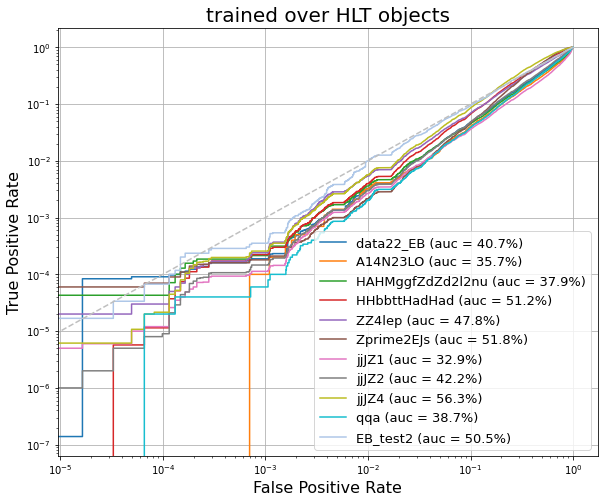

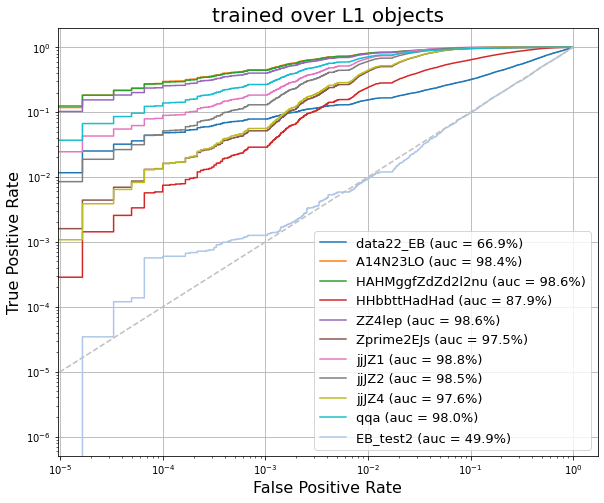

In [30]:
HLT_TPRs, HLT_AUCs, HLT_thresholds = ROC_curve(datasets, bkg_type='HLT')
L1_TPRs, L1_AUCs, L1_thresholds = ROC_curve(datasets, bkg_type='L1')

## latent_dim = 12

In [ ]:
HLT_TPRs, HLT_AUCs, HLT_thresholds = ROC_curve(datasets, bkg_type='HLT')
L1_TPRs, L1_AUCs, L1_thresholds = ROC_curve(datasets, bkg_type='L1')

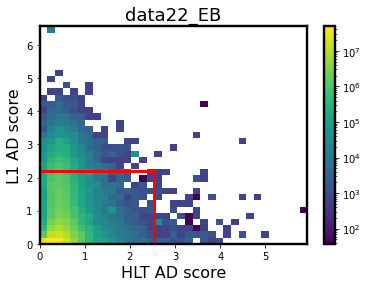

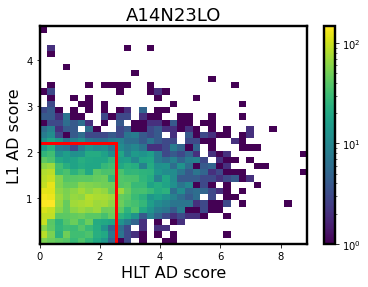

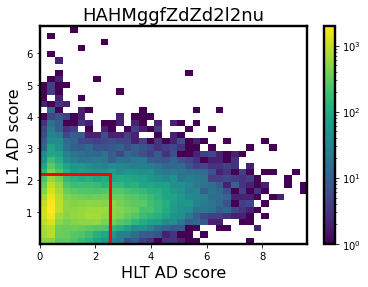

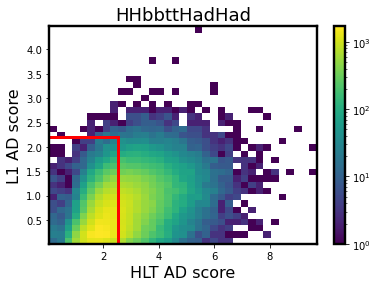

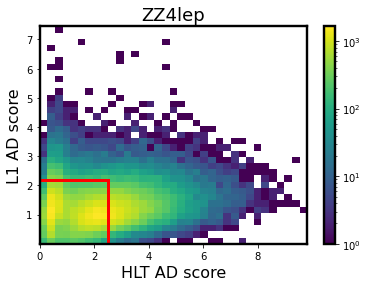

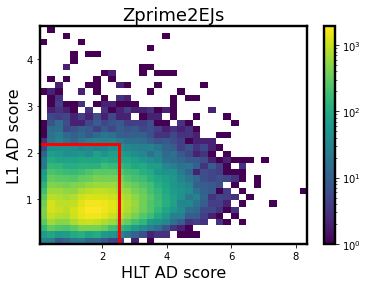

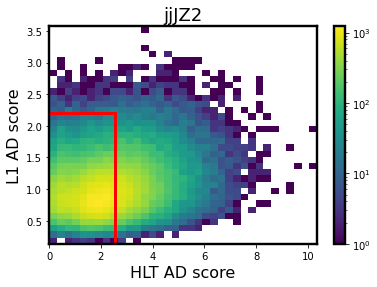

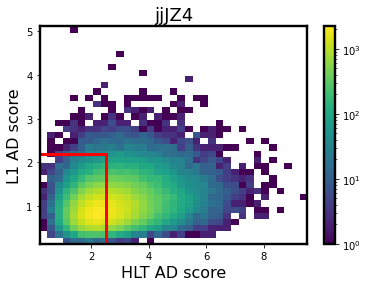

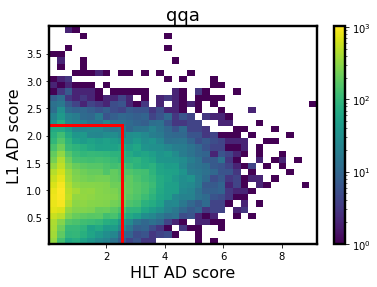

KeyError: 'HLT_AD_scores'

In [31]:
#plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins=35

for tag in datasets.keys():
    plt.hist2d(datasets[tag]['HLT_AD_scores'], datasets[tag]['L1_AD_scores'], bins=bins, cmap='viridis', norm=matplotlib.colors.LogNorm(), weights=datasets[tag]['weights'])
    plt.plot(np.linspace(0, L1_thresholds[tag], 10), HLT_thresholds[tag]*np.ones(10), color='r', linewidth=3)
    plt.plot(L1_thresholds[tag]*np.ones(10), np.linspace(0, HLT_thresholds[tag], 10), color='r', linewidth=3)
    plt.colorbar()
    plt.xlabel(f'HLT AD score', fontsize=16)
    plt.ylabel(f'L1 AD score', fontsize=16)
    plt.title(f'{tag}', fontsize=18)
    plt.show()

## Old

<Figure size 1296x720 with 0 Axes>

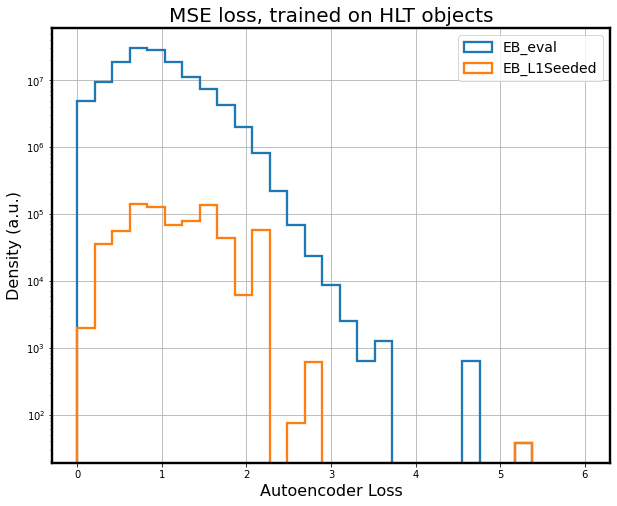

In [170]:
# Plot a histogram of the HLT AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
bins=np.linspace(0, 6, 30)
plt.figure(figsize=(10,8))
for tag, dict in datasets.items():
    if tag in ['EB_eval', 'EB_L1Seeded']:
        plt.hist(dict['HLT_AD_scores'], bins=bins, label=tag, density = False, histtype='step', fill=False, linewidth=2.3, weights=dict['weights'])


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss, trained on HLT objects', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

<Figure size 1296x720 with 0 Axes>

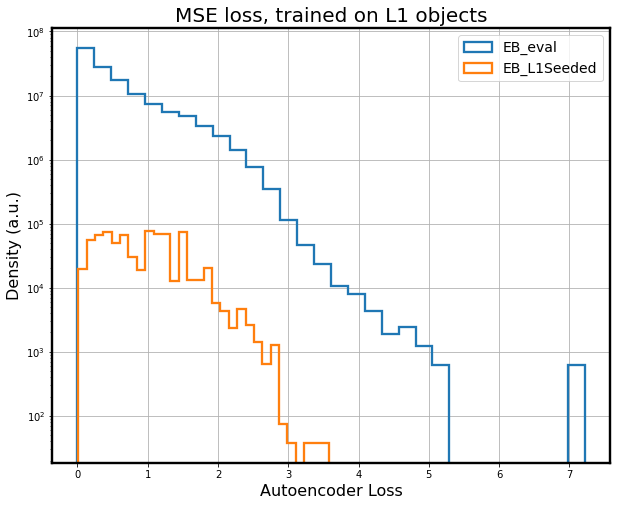

In [169]:
# Plot a histogram of the L1 AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for tag, dict in datasets.items():
    if tag in ['EB_eval', 'EB_L1Seeded']:
        plt.hist(dict['my_L1_AD_scores'], bins=bins, label=tag, density = False, histtype='step', fill=False, linewidth=2.3, weights=dict['weights'])


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss, trained on L1 objects', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

HLT_zerobias: TPR at FPR of 10^-4 is 0.00004 with threshold 3.8875
HLT_passedHLT: TPR at FPR of 10^-4 is 0.00000 with threshold 3.8875
HLT_Ztautau: TPR at FPR of 10^-4 is 0.00015 with threshold 3.8875
HLT_ZZ4lep: TPR at FPR of 10^-4 is 0.00103 with threshold 3.8875
HLT_qqa: TPR at FPR of 10^-4 is 0.00020 with threshold 3.8875
HLT_HNL7p5_ctau1_eemu: TPR at FPR of 10^-4 is 0.00040 with threshold 3.8875
HLT_Zprime2EJs: TPR at FPR of 10^-4 is 0.00011 with threshold 3.8875
HLT_HAHMggfZdZd2l2nu: TPR at FPR of 10^-4 is 0.00200 with threshold 3.8875
HLT_HHbbttHadHad: TPR at FPR of 10^-4 is 0.00114 with threshold 3.8875
HLT_jjJZ4: TPR at FPR of 10^-4 is 0.00024 with threshold 3.8875
HLT_jjJZ2: TPR at FPR of 10^-4 is 0.00016 with threshold 3.8875
HLT_test2: TPR at FPR of 10^-4 is 0.00004 with threshold 3.8875


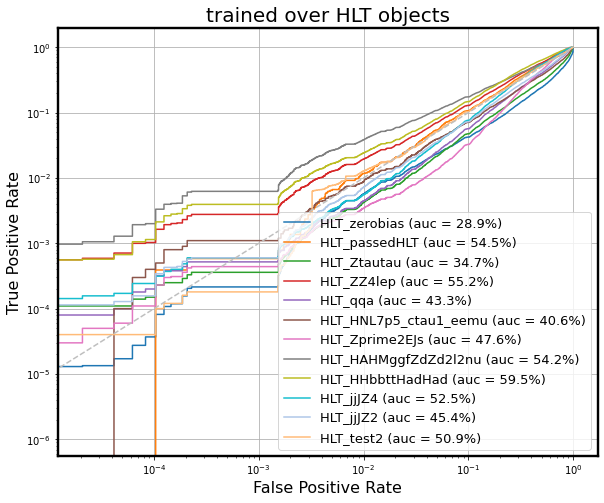

In [30]:
# Plot the HLT ROC curves

target_background = np.zeros(AD_scores['HLT_test1'].shape[0])
target_fpr = 10**-4
plt.figure(figsize=(8.5,6.8))

FPR = {}
TPR = {}
thresholds = {}

for tag in AD_scores.keys():
    if tag.startswith('HLT') and tag != 'HLT_test1':
    
        # Combine true labels, anomaly=1 and background=0
        trueVal = np.concatenate((np.ones(AD_scores[tag].shape[0]), target_background))
        
        # Combine predictions from current dataset and background
        predVal_loss = np.concatenate((AD_scores[tag], AD_scores['HLT_test1']))
    
        sample_weights = np.concatenate((weights[tag], weights['HLT_test1']))
    
        # Calculate ROC curve and AUC, including weights
        fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
        auc_loss = auc(fpr_loss, tpr_loss)

        FPR[tag] = fpr_loss
        TPR[tag] = tpr_loss
        thresholds[tag] = threshold_loss
    
        # Plot ROC curve
        plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)
    
        # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        
        if tag == 'HLT_test2': 
            HLT_threshold = threshold_loss[idx]
            #plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value
        
        print(f"{tag}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.5f} with threshold {threshold_loss[idx]:.4f}")

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.title('trained over HLT objects', fontsize=20)

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

L1_zerobias: TPR at FPR of 10^-4 is 0.00004 with threshold 4.0142
L1_passedHLT: TPR at FPR of 10^-4 is 0.00019 with threshold 4.2014
L1_HHbbttHadHad: TPR at FPR of 10^-4 is 0.00002 with threshold 4.2014
L1_jjJZ4: TPR at FPR of 10^-4 is 0.00002 with threshold 4.2014
L1_jjJZ2: TPR at FPR of 10^-4 is 0.00002 with threshold 4.2014
L1_test2: TPR at FPR of 10^-4 is 0.00004 with threshold 4.2014


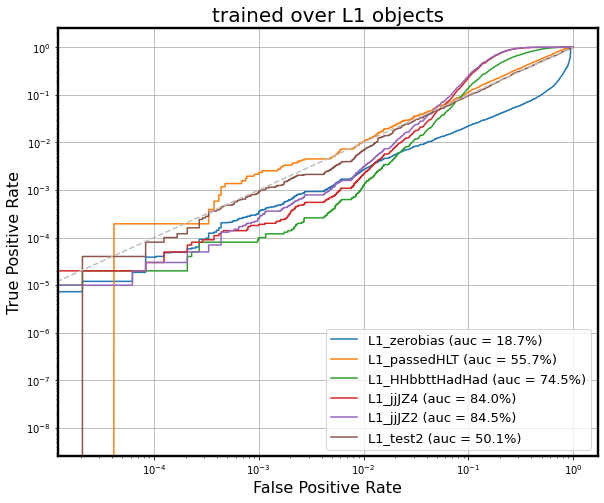

In [31]:
# Plot the HLT ROC curves

target_background = np.zeros(AD_scores['L1_test1'].shape[0])
target_fpr = 10**-4
plt.figure(figsize=(8.5,6.8))

for tag in AD_scores.keys():
    if tag.startswith('L1') and tag != 'L1_test1':
    
        # Combine true labels, anomaly=1 and background=0
        trueVal = np.concatenate((np.ones(AD_scores[tag].shape[0]), target_background))
        
        # Combine predictions from current dataset and background
        predVal_loss = np.concatenate((AD_scores[tag], AD_scores['L1_test1']))
    
        sample_weights = np.concatenate((weights[tag], weights['L1_test1']))
    
        # Calculate ROC curve and AUC, including weights
        fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
        auc_loss = auc(fpr_loss, tpr_loss)

        FPR[tag] = fpr_loss
        TPR[tag] = tpr_loss
        thresholds[tag] = threshold_loss
    
        # Plot ROC curve
        plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)
    
        # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        
        if tag == 'L1_test2': 
            L1_threshold = threshold_loss[idx]
            #plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value

        print(f"{tag}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.5f} with threshold {threshold_loss[idx]:.4f}")


# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.title('trained over L1 objects', fontsize=20)

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

In [32]:
for tag in model_outputs.keys():
    if tag in skip_tags: continue
    mask = datasets[tag] != 0
    
    diff = (datasets[tag] - model_outputs[tag]) * mask
    
    mean = np.average(np.abs(diff), axis=0, weights=weights[tag])
    std = np.average((np.abs(diff) - mean)**2, axis=0).reshape(20, 3)
    mean = mean.reshape(20, 3)
    
    print(f"abs({tag} event - reconstruction)")
    for i in range(20):
        print(f'{mean[i, 0]:.3f} +- {std[i, 0]:.3f}     {mean[i, 1]:.3f} +- {std[i, 1]:.3f}     {mean[i, 2]:.3f} +- {std[i, 2]:.3f}')

abs(HLT_zerobias event - reconstruction)
0.070 +- 0.009     0.983 +- 0.926     0.981 +- 0.775
0.036 +- 0.001     1.375 +- 1.672     1.304 +- 1.045
0.024 +- 0.001     1.283 +- 1.797     1.270 +- 1.044
0.023 +- 0.000     0.604 +- 0.583     1.212 +- 1.055
0.020 +- 0.000     0.849 +- 1.199     1.143 +- 1.075
0.017 +- 0.000     0.818 +- 1.254     1.059 +- 1.091
0.014 +- 0.000     0.773 +- 1.263     0.975 +- 1.104
0.011 +- 0.000     0.700 +- 1.208     0.886 +- 1.108
0.009 +- 0.000     0.619 +- 1.129     0.804 +- 1.102
0.008 +- 0.000     0.549 +- 1.051     0.721 +- 1.083
0.000 +- 0.000     0.000 +- 0.004     0.000 +- 0.007
0.000 +- 0.000     0.000 +- 0.000     0.000 +- 0.001
0.000 +- 0.000     0.000 +- 0.000     0.000 +- 0.000
0.000 +- 0.000     0.003 +- 0.019     0.004 +- 0.044
0.000 +- 0.000     0.000 +- 0.002     0.000 +- 0.004
0.000 +- 0.000     0.000 +- 0.000     0.000 +- 0.000
0.010 +- 0.002     0.411 +- 0.464     0.409 +- 0.470
0.007 +- 0.001     0.273 +- 0.387     0.269 +- 0.399
0.003

In [33]:
HLT_mask = datasets['HLT_test1'] != 0
L1_mask = datasets['L1_test1'] != 0

HLT_diff = (datasets['HLT_test1'] - model_outputs['HLT_test1']) * HLT_mask
L1_diff = (datasets['L1_test1'] - model_outputs['L1_test1']) * L1_mask

HLT_mean = np.average(np.abs(HLT_diff), axis=0, weights=weights['HLT_test1'])
HLT_std = np.average((np.abs(HLT_diff) - HLT_mean)**2, axis=0).reshape(20, 3)
HLT_mean = HLT_mean.reshape(20, 3)

L1_mean = np.average(np.abs(L1_diff), axis=0, weights=weights['L1_test1'])
L1_std = np.average((np.abs(L1_diff) - L1_mean)**2, axis=0).reshape(20, 3)
L1_mean = L1_mean.reshape(20, 3)

print("abs(HLT event - reconstruction)")
for i in range(20):
    print(f'{HLT_mean[i, 0]:.3f} +- {HLT_std[i, 0]:.3f}     {HLT_mean[i, 1]:.3f} +- {HLT_std[i, 1]:.3f}     {HLT_mean[i, 2]:.3f} +- {HLT_std[i, 2]:.3f}')

print("abs(L1 event - reconstruction)")
for i in range(20):
    print(f'{L1_mean[i, 0]:.3f} +- {L1_std[i, 0]:.3f}     {L1_mean[i, 1]:.3f} +- {L1_std[i, 1]:.3f}     {L1_mean[i, 2]:.3f} +- {L1_std[i, 2]:.3f}')

abs(HLT event - reconstruction)
0.056 +- 0.004     1.039 +- 0.791     1.249 +- 0.744
0.039 +- 0.001     1.440 +- 1.308     1.528 +- 0.901
0.025 +- 0.001     1.680 +- 1.504     1.534 +- 0.878
0.022 +- 0.000     0.905 +- 0.642     1.513 +- 0.885
0.019 +- 0.000     1.363 +- 1.365     1.485 +- 0.914
0.017 +- 0.000     1.413 +- 1.456     1.440 +- 0.942
0.015 +- 0.000     1.407 +- 1.555     1.396 +- 0.983
0.013 +- 0.000     1.330 +- 1.583     1.312 +- 1.018
0.012 +- 0.000     1.227 +- 1.526     1.227 +- 1.050
0.011 +- 0.000     1.139 +- 1.496     1.160 +- 1.080
0.000 +- 0.000     0.003 +- 0.004     0.004 +- 0.009
0.000 +- 0.000     0.001 +- 0.001     0.001 +- 0.002
0.000 +- 0.000     0.000 +- 0.000     0.000 +- 0.000
0.006 +- 0.000     0.187 +- 0.247     0.296 +- 0.550
0.000 +- 0.000     0.020 +- 0.027     0.028 +- 0.057
0.000 +- 0.000     0.003 +- 0.004     0.004 +- 0.010
0.020 +- 0.000     0.653 +- 0.401     0.741 +- 0.442
0.019 +- 0.000     0.567 +- 0.370     0.662 +- 0.424
0.011 +- 0.000

# Everything below here is from an earlier version of the code and hasn't been updated. 
# It's left here so one can see how this kind of thing is done for ease in the future

In [31]:
# Print HLT overlaps
print(f'MODEL THAT TRAINED OVER HLT OBJECTS::::::')

for tag, data in AD_scores.items():
    if tag.startswith('HLT') and tag != 'HLT_passedHLT':
        anomaly_idxs = data > HLT_threshold
        HLT_overlap = 0
        inverse_overlap = 0
        idx = 0
        for a, h in zip(anomaly_idxs, pass_HLT[tag]):
            if a==1 and h==1:
                HLT_overlap += weights[tag][idx]
            if a==1 or h==1:
                inverse_overlap += weights[tag][idx]
            idx += 1
    
        HLT_overlap /= np.sum(anomaly_idxs * weights[tag])
        inverse_overlap /= np.sum(pass_HLT[tag] * weights[tag])
    
        print(f'-----\n{tag}:')
        print(f'HLT overlap: {HLT_overlap}')
        print(f'inverse overlap: {inverse_overlap}')
        print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT[tag]) / len(pass_HLT[tag])}')
        print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
        print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER HLT OBJECTS::::::
-----
HLT_zerobias:
HLT overlap: 0.00014975945199250689
inverse overlap: 7.728444572115307
percentage of events that passed some HLT trigger: 0.0010400489555800105
percentage of events that we tagged as anomalous: 5.913751786981518e-05
number of events that we tagged as anomalous: 46
-----
HLT_Ztautau:
HLT overlap: 0.14043583535108958
inverse overlap: 1.0533273246207
percentage of events that passed some HLT trigger: 0.06657
percentage of events that we tagged as anomalous: 0.00413
number of events that we tagged as anomalous: 413
-----
HLT_ZZ4lep:
HLT overlap: 0.9362206689965052
inverse overlap: 1.0058614361091993
percentage of events that passed some HLT trigger: 0.8718
percentage of events that we tagged as anomalous: 0.08012
number of events that we tagged as anomalous: 8012
-----
HLT_qqa:
HLT overlap: 0.1518987341772152
inverse overlap: 1.1038299756475536
percentage of events that passed some HLT trigger: 0.09034
percentage of events that 

In [32]:
# Print L1 overlaps
print(f'MODEL THAT TRAINED OVER L1 OBJECTS::::::')

for tag, data in AD_scores.items():
    if tag.startswith('L1') and tag not in ['L1_passedHLT', 'L1_zerobias']:
        anomaly_idxs = data > L1_threshold
        HLT_overlap = 0
        inverse_overlap = 0
        idx = 0
        for a, h in zip(anomaly_idxs, pass_HLT[tag]):
            if a==1 and h==1:
                HLT_overlap += weights[tag][idx]
            if a==1 or h==1:
                inverse_overlap += weights[tag][idx]
            idx += 1
    
        HLT_overlap /= np.sum(anomaly_idxs * weights[tag])
        inverse_overlap /= np.sum(pass_HLT[tag] * weights[tag])
    
        print(f'-----\n{tag}:')
        print(f'HLT overlap: {HLT_overlap}')
        print(f'inverse overlap: {inverse_overlap}')
        print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT[tag]) / len(pass_HLT[tag])}')
        print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
        print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER L1 OBJECTS::::::
-----
L1_HHbbttHadHad:
HLT overlap: 1.0
inverse overlap: 1.0
percentage of events that passed some HLT trigger: 0.5459
percentage of events that we tagged as anomalous: 3e-05
number of events that we tagged as anomalous: 3
-----
L1_jjJZ4:
HLT overlap: 0.9285714285714286
inverse overlap: 1.0000101874490628
percentage of events that passed some HLT trigger: 0.9816
percentage of events that we tagged as anomalous: 0.00014
number of events that we tagged as anomalous: 14
-----
L1_jjJZ2:
HLT overlap: 0.0
inverse overlap: 1.0074766355140188
percentage of events that passed some HLT trigger: 0.0107
percentage of events that we tagged as anomalous: 8e-05
number of events that we tagged as anomalous: 8
-----
L1_test1:
HLT overlap: 0.0
inverse overlap: 1.0048423773076038
percentage of events that passed some HLT trigger: 0.032077277076593615
percentage of events that we tagged as anomalous: 9.112862805850458e-05
number of events that we tagged as anomalou

In [33]:
threshold = HLT_threshold

anomaly_idxs = (AD_scores['HLT_test2'] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
HLT_acceptance = np.sum(weights['HLT_test2'] * pass_HLT['HLT_test2']) / np.sum(weights['HLT_test2'])
HLT_AD_acceptance = np.sum(weights['HLT_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['HLT_test2'])) / np.sum(weights['HLT_test2'])

# Multiply by 100,000 since there are 100,000Hz going INTO the HLT
# HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)
print(f'additional rate at 10e-4: {(HLT_AD_acceptance - HLT_acceptance) * 100000}')

additional rate at 10e-4: 10.050219915943432


In [48]:
HLT_rates = []
for i, fpr in enumerate(FPR['HLT_test2']):
    threshold = thresholds['HLT_test2'][i]
    
    anomaly_idxs = (AD_scores['HLT_test2'] > threshold) 
    HLT_acceptance = np.sum(weights['HLT_test2'] * pass_HLT['HLT_test2']) / np.sum(weights['HLT_test2'])
    HLT_AD_acceptance = np.sum(weights['HLT_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['HLT_test2'])) / np.sum(weights['HLT_test2'])
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f"progress: {i} / {len(FPR['HLT_test2'])}")

progress: 1 / 56819
progress: 10001 / 56819
progress: 20001 / 56819
progress: 30001 / 56819
progress: 40001 / 56819
progress: 50001 / 56819


In [49]:
L1_rates = []
for i, fpr in enumerate(FPR['L1_test2']):
    threshold = thresholds['L1_test2'][i]

    anomaly_idxs = (AD_scores['L1_test2'] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights['L1_test2'] * pass_HLT['L1_test2']) / np.sum(weights['L1_test2'])
    HLT_AD_acceptance = np.sum(weights['L1_test2'] * np.bitwise_or(anomaly_idxs, pass_HLT['L1_test2'])) / np.sum(weights['L1_test2'])
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    L1_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f"progress: {i} / {len(FPR['L1_test2'])}")

progress: 1 / 56868
progress: 10001 / 56868
progress: 20001 / 56868
progress: 30001 / 56868
progress: 40001 / 56868
progress: 50001 / 56868


In [50]:
print(len(FPR['HLT_test2']))
      
print(len(HLT_rates))

56819
56819


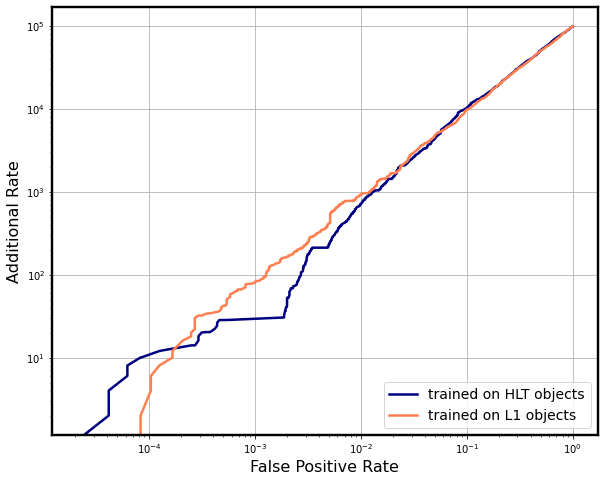

In [51]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(FPR['HLT_test2'], HLT_rates, color='navy', linewidth=2.5, label='trained on HLT objects')
plt.plot(FPR['L1_test2'], L1_rates, color='coral', linewidth=2.5, label='trained on L1 objects')

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

#plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("Additional Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=14)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

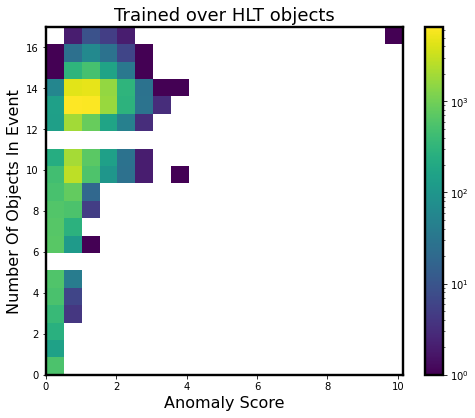

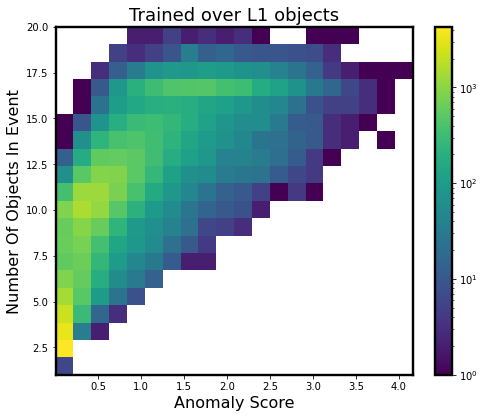

In [56]:
# Make a histogram of multiplicity vs anomaly score

HLT_pt_values = datasets['HLT_test2'].reshape(-1, 20, 3)[:, :, 0]
L1_pt_values = datasets['L1_test2'].reshape(-1, 20, 3)[:, :, 0]
HLT_num_objects = np.count_nonzero(HLT_pt_values, axis=1)
L1_num_objects = np.count_nonzero(L1_pt_values, axis=1)

plt.figure(figsize=(8, 6.4))
plt.rcParams['axes.linewidth'] = 2.4
plt.hist2d(AD_scores['HLT_test2'], HLT_num_objects, bins=20, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel(f'Anomaly Score', fontsize=16)
plt.ylabel(f'Number Of Objects In Event', fontsize=16)
plt.title('Trained over HLT objects', fontsize=18)
plt.show()

plt.figure(figsize=(8, 6.4))
plt.rcParams['axes.linewidth'] = 2.4
plt.hist2d(AD_scores['L1_test2'], L1_num_objects, bins=20, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel(f'Anomaly Score', fontsize=16)
plt.ylabel(f'Number Of Objects In Event', fontsize=16)
plt.title('Trained over L1 objects', fontsize=18)
plt.show()

In [39]:
# now I need to figure out, at some specific FPR, the overlap between HLT and the L1

In [40]:
HLT_anomaly_idxs = HLT_AD_scores[1] > HLT_threshold
L1_anomaly_idxs = L1_AD_scores[1] > L1_threshold

num_overlaps = np.sum(np.bitwise_and(HLT_anomaly_idxs, L1_anomaly_idxs))
num_HLT_anomalies = np.sum(HLT_anomaly_idxs)
num_L1_anomalies = np.sum(L1_anomaly_idxs)

# Calculate the fractions
f_HLT = (num_overlaps / num_HLT_anomalies)
f_L1 = (num_overlaps / num_L1_anomalies)

print(f'number of events that both the HLT and L1 models flagged as anomalous: {num_overlaps}')
print(f'out of the HLT anomalies, what fraction are also L1 anomalies? {f_HLT}')
print(f'out of the L1 anomalies, what fraction are also HLT anomalies? {f_L1}')

number of events that both the HLT and L1 models flagged as anomalous: 0
out of the HLT anomalies, what fraction are also L1 anomalies? 0.0
out of the L1 anomalies, what fraction are also HLT anomalies? 0.0


In [41]:
print(f'number of L1 anomalies: {num_L1_anomalies}')
print(f'number of HLT anomalies: {num_HLT_anomalies}')

number of L1 anomalies: 7
number of HLT anomalies: 8


In [76]:
# Let's take a closer look at these anomalies
HLT_anomalies = HLT_y_true[1][HLT_anomaly_idxs]
HLT_anom_outputs = HLT_model_outputs[1][HLT_anomaly_idxs]
L1_anomalies = L1_y_true[1][L1_anomaly_idxs]
L1_anom_outputs = L1_model_outputs[1][L1_anomaly_idxs]

print(f'Anomalies found by model trained on HLT objects:')
for i in range(len(HLT_anomalies)):
    print(f'event:\n{HLT_anomalies[i].reshape(-1, 20, 3)}')
    print(f'reconstruction:\n{HLT_anom_outputs[i].reshape(-1, 20, 3)}')

print(f'Anomalies found by model trained on L1 objects:')
for i in range(len(L1_anomalies)):
    print(f'event:\n{L1_anomalies[i].reshape(-1, 20, 3)}')
    print(f'reconstruction:\n{L1_anom_outputs[i].reshape(-1, 20, 3)}')

Anomalies found by model trained on HLT objects:
event:
[[[ 0.18945431  0.4822886  -0.30662119]
  [ 0.14006709  0.0747449   2.48758316]
  [ 0.10698286 -4.40890455  2.29233575]
  [ 0.10339661 -3.51014018 -0.84333491]
  [ 0.08084805  4.40199375 -2.6154201 ]
  [ 0.05505495  3.06775713 -2.3277216 ]
  [ 0.05356225  4.37638283  0.78126425]
  [ 0.04481367 -2.55221438 -0.62268186]
  [ 0.04245868  1.20024025  2.29764962]
  [ 0.03930756  2.72266507  3.05115509]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.06237572  0.03229186  2.51828933]
  [ 0.06237572  0.03229186  2.51828933]
  [ 0.01930252  0.49109831 -0.34072194]
  [ 0.          0.          0.        ]]]
reconstruction:
[[[ 0.07721651 -2.3509588   0.15923315]
  [ 0.09922105 -1.2720616   3.5524993 ]
  [ 0.08455377 -3.1708102  -0.55961454]
  [ 0.

In [42]:
# Print HLT overlaps
print(f'MODEL THAT TRAINED OVER HLT OBJECTS::::::')

for i, tag in enumerate(HLT_tags):
    anomaly_idxs = HLT_AD_scores[i] > HLT_threshold
    HLT_overlap = 0
    inverse_overlap = 0
    for a, h in zip(anomaly_idxs, pass_HLT_list[i]):
        if a==1 and h==1:
            HLT_overlap += 1
        if a==1 or h==1:
            inverse_overlap += 1

    HLT_overlap /= np.sum(anomaly_idxs)
    inverse_overlap /= np.sum(pass_HLT_list[i])

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'inverse overlap: {inverse_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_list[i]) / len(pass_HLT_list[i])}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER HLT OBJECTS::::::
-----
data (background):
HLT overlap: 0.0
inverse overlap: 1.0028308563340411
percentage of events that passed some HLT trigger: 0.03197917845422655
percentage of events that we tagged as anomalous: 9.052845988457622e-05
number of events that we tagged as anomalous: 4
-----
HLT:
HLT overlap: 0.0
inverse overlap: 1.0056100981767182
percentage of events that passed some HLT trigger: 0.03266222313841362
percentage of events that we tagged as anomalous: 0.00018323827847637373
number of events that we tagged as anomalous: 8
-----
zerobias:
HLT overlap: 0.0
inverse overlap: 1.0469798657718121
percentage of events that passed some HLT trigger: 0.0009563236096402554
percentage of events that we tagged as anomalous: 4.492795481531401e-05
number of events that we tagged as anomalous: 7
-----
HHbbttHadHad:
HLT overlap: 0.5757575757575758
inverse overlap: 1.0038627793617216
percentage of events that passed some HLT trigger: 0.54365
percentage of events tha

In [43]:
# Print L1 overlaps
print(f'MODEL THAT TRAINED OVER L1 OBJECTS::::::')

for i, tag in enumerate(L1_tags):
    anomaly_idxs = L1_AD_scores[i] > L1_threshold
    HLT_overlap = 0
    inverse_overlap = 0
    for a, h in zip(anomaly_idxs, pass_HLT_list[i]):
        if a==1 and h==1:
            HLT_overlap += 1
        if a==1 or h==1:
            inverse_overlap += 1

    HLT_overlap /= np.sum(anomaly_idxs)
    inverse_overlap /= np.sum(pass_HLT_list[i])

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'inverse overlap: {inverse_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_list[i]) / len(pass_HLT_list[i])}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER L1 OBJECTS::::::
-----
data (background):
HLT overlap: 0.2
inverse overlap: 1.0028308563340411
percentage of events that passed some HLT trigger: 0.03197917845422655
percentage of events that we tagged as anomalous: 0.00011316057485572027
number of events that we tagged as anomalous: 5
-----
L1 objects:
HLT overlap: 0.0
inverse overlap: 1.0049088359046283
percentage of events that passed some HLT trigger: 0.03266222313841362
percentage of events that we tagged as anomalous: 0.000160333493666827
number of events that we tagged as anomalous: 7
-----
zerobias:
HLT overlap: 0.0
inverse overlap: 1.0268456375838926
percentage of events that passed some HLT trigger: 0.0009563236096402554
percentage of events that we tagged as anomalous: 2.5673117037322294e-05
number of events that we tagged as anomalous: 4


In [65]:
HLT_rates = []
HLT_num_objects = []
for i, fpr in enumerate(HLT_fpr_loss):
    threshold = HLT_threshold_loss[i]

    anomaly_idxs = (HLT_AD_scores[1] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights_list[1] * pass_HLT_list[1]) / np.sum(weights_list[1])
    HLT_AD_acceptance = np.sum(weights_list[1] * np.bitwise_or(anomaly_idxs, pass_HLT_list[1])) / np.sum(weights_list[1])

    pt_values = HLT_y_true[1][anomaly_idxs].reshape(-1, 20, 3)[:, :, 0]
    anom_weights = weights_list[1][anomaly_idxs]
    if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
    num_objects_per_event = np.count_nonzero(pt_values, axis=1)
    #HLT_num_objects.append(np.average(num_objects_per_event, weights=anom_weights))
    HLT_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f'progress: {i} / {len(HLT_fpr_loss)}')

/tmp/ipykernel_372/3218523813.py:15: RuntimeWarning: invalid value encountered in double_scalars
  HLT_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))


progress: 1 / 57940
progress: 10001 / 57940
progress: 20001 / 57940
progress: 30001 / 57940
progress: 40001 / 57940
progress: 50001 / 57940


In [66]:
L1_rates = []
L1_num_objects = []
for i, fpr in enumerate(L1_fpr_loss):
    threshold = L1_threshold_loss[i]

    anomaly_idxs = (L1_AD_scores[1] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights_list[1] * pass_HLT_list[1]) / np.sum(weights_list[1])
    HLT_AD_acceptance = np.sum(weights_list[1] * np.bitwise_or(anomaly_idxs, pass_HLT_list[1])) / np.sum(weights_list[1])

    pt_values = L1_y_true[1][anomaly_idxs].reshape(-1, 20, 3)[:, :, 0]
    anom_weights = weights_list[1][anomaly_idxs]
    if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
    num_objects_per_event = np.count_nonzero(pt_values, axis=1)
    L1_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    L1_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f'progress: {i} / {len(L1_fpr_loss)}')

progress: 1 / 127979
progress: 10001 / 127979
progress: 20001 / 127979
progress: 30001 / 127979
progress: 40001 / 127979
progress: 50001 / 127979
progress: 60001 / 127979
progress: 70001 / 127979
progress: 80001 / 127979
progress: 90001 / 127979
progress: 100001 / 127979
progress: 110001 / 127979
progress: 120001 / 127979


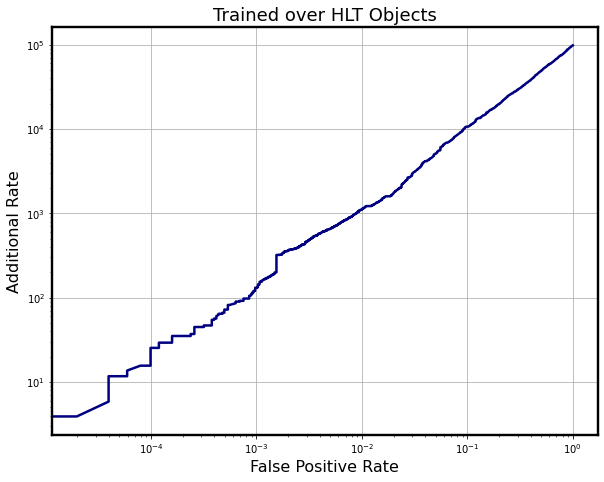

In [67]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(HLT_fpr_loss, HLT_rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("Additional Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

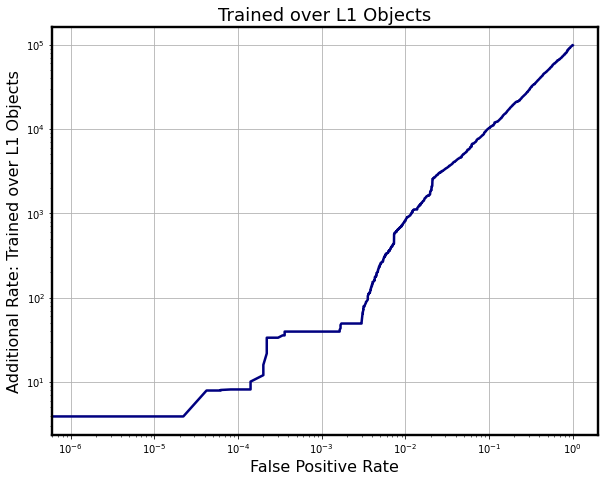

In [68]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(L1_fpr_loss, L1_rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

plt.title('Trained over L1 Objects', fontsize=18)
plt.ylabel("Additional Rate: Trained over L1 Objects", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

In [69]:
target_fpr = 10**-4
HLT_idx = np.argmin(np.abs(HLT_fpr_loss - target_fpr))
L1_idx = np.argmin(np.abs(L1_fpr_loss - target_fpr))

print(f'Pure rate at fpr=10e-4: {HLT_rates[HLT_idx]} (trained over HLT objects)')
print(f'Pure rate at fpr=10e-4: {L1_rates[L1_idx]} (trained over L1 objects)')

Pure rate at fpr=10e-4: 15.612964742042074 (trained over HLT objects)
Pure rate at fpr=10e-4: 8.156675357946785 (trained over L1 objects)


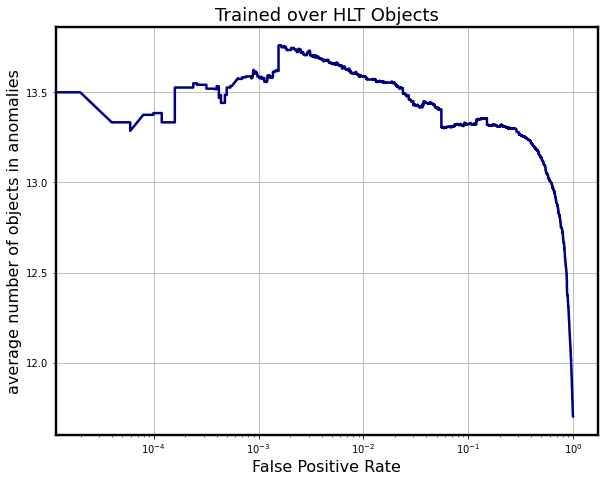

In [72]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(HLT_fpr_loss, HLT_num_objects, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
#plt.semilogy()

plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("average number of objects in anomalies", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

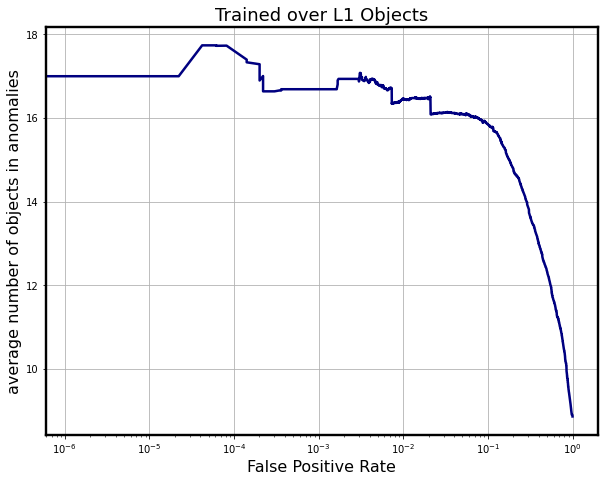

In [73]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(L1_fpr_loss, L1_num_objects, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
#plt.semilogy()

plt.title('Trained over L1 Objects', fontsize=18)
plt.ylabel("average number of objects in anomalies", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

In [74]:
pt_values = HLT_y_true[1].reshape(-1, 20, 3)[:, :, 0]
anom_weights = weights_list[1]
if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
num_objects_per_event = np.count_nonzero(pt_values, axis=1)
HLT_num_objs = (np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
print(f'average number of objects per event in the whole test data with HLT objects: {HLT_num_objs}')

average number of objects per event in the whole test data with HLT objects: 11.692775578449224


In [75]:
pt_values = L1_y_true[1].reshape(-1, 20, 3)[:, :, 0]
anom_weights = weights_list[1]
if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
num_objects_per_event = np.count_nonzero(pt_values, axis=1)
L1_num_objs = (np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
print(f'average number of objects per event in the whole test data with L1 objects: {L1_num_objs}')

average number of objects per event in the whole test data with L1 objects: 8.855968094629004
